# Time Series Analysis: Tutorial 2

We have two options to model the long term component of a time series:
    
    1. Parametric (global) approach
    2. Flexible (local) approach
    
In this tutorial we follow the second approach and model the long term trend using flexible approaches. We investigate further on the following options:

- Moving Averages 
- Hodrick-Prescott Filter

Terminology: 

- Smoothing: determining $L_t$ or $G_t$
- Filtering: Remove $S_t$ or $I_t$

## Import Packages

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('text', usetex=True)
import pandas as pd
import statsmodels.api as sm

## Load Data

In [2]:
# Load the oil-, Siemens-, production- and unemployment-datasets.
oil=pd.read_stata('oil.dta')
siemens=pd.read_stata('Siemens.dta')
prod=pd.read_stata('prod.dta')
unemp=pd.read_stata('unemp.dta')
time = pd.date_range(start="2000", periods=105, freq="M")
data = pd.DataFrame(time, columns=['date'])
oil=data.assign(oil=oil.values)
oil

,date,oil
0,2000-01-31,82.599998
1,2000-02-29,91.199997
2,2000-03-31,94.300003
3,2000-04-30,82.900002
4,2000-05-31,94.900002
...,...,...
100,2008-05-31,262.600006
101,2008-06-30,283.000000
102,2008-07-31,288.399994
103,2008-08-31,269.799988


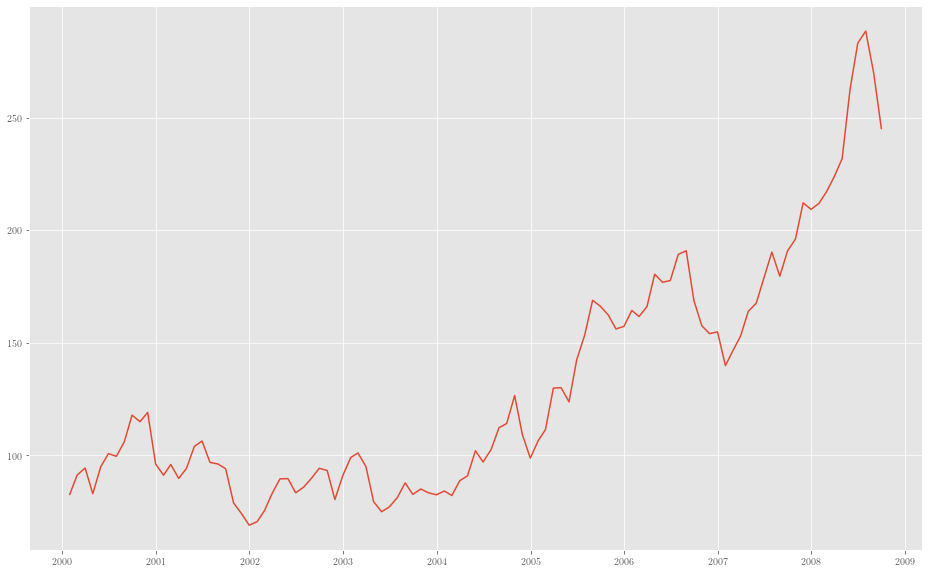

In [3]:
# Plot the crude oil import price index.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])

## Exponentially Weighted Moving Average

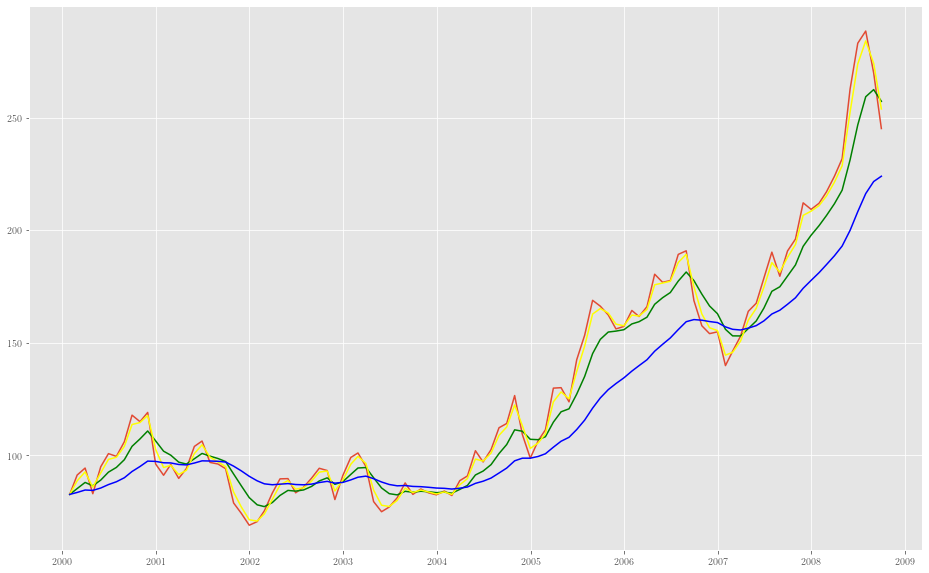

In [7]:
# Generate smoothed data via exponentially weighted moving average (EWMA) for the crude oil import price index
def EWMA(data,alpha):
    data_smoothed=[data[0]]
    for i in range(1,len(data)):
        smooth=alpha*data[i]+(1-alpha)*data_smoothed[i-1]
        data_smoothed.append(smooth)
    return data_smoothed
    
oil_smoothed_03=EWMA(oil['oil'].values,0.3) 
oil_smoothed_07=EWMA(oil['oil'].values,0.7)
oil_smoothed_01=EWMA(oil['oil'].values,0.1)

# Plot the crude oil import price index.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])
plt.plot(oil['date'],oil_smoothed_03,c='green')  # green = 0.3
plt.plot(oil['date'],oil_smoothed_07,c='yellow') # yellow = 0.7
plt.plot(oil['date'],oil_smoothed_01,c='blue')   # blue = 0.1

Is the model appropriate to predict the oil price? Justify with the help of the graph, in particular, investigate the years after 2004. In order to answer this question you should consider the properties of exponential smoothing where we smooth the observed data $\{y_t\}_{t=1}^n$ via

\begin{align}
\tilde{y}_0&=y_0\\
\tilde{y}_t&=\alpha y_t+(1-\alpha)\tilde{y}_{t-1}\text{ for } t\geqslant1
\end{align}

and some $\alpha\in(0,1)$ in order to obtain smoothed data $\{\tilde{y}_t\}_{t=1}^n$.

#### Question: is (one of the) specified EWMA models appropriate for forecasting the oil price? Why is this the case? 

Summary simple exponential smoothing: 

- Technique for a univariate time series.
- The goal is to forecast future values.
- Idea is to use a weighted average of all the previous values in the series. 
- Method can be used to predict series that do not have trends or seasonality.
- It involves a parameter called alpha, which is the smoothing parameter. 
- Core idea is to use exponentially decreasing weights, with higher weight assigned to the most recent observation. 

## Combining linear trend with smoothing

We have seen that the performance of EWMA is not so good if there is a trend. 

We therefore remove the trend first, and then smooth the series. 

In [10]:
# Calculate the EWMA. Use the first observation as the initial value and α =.3 as the smoothing parameter.

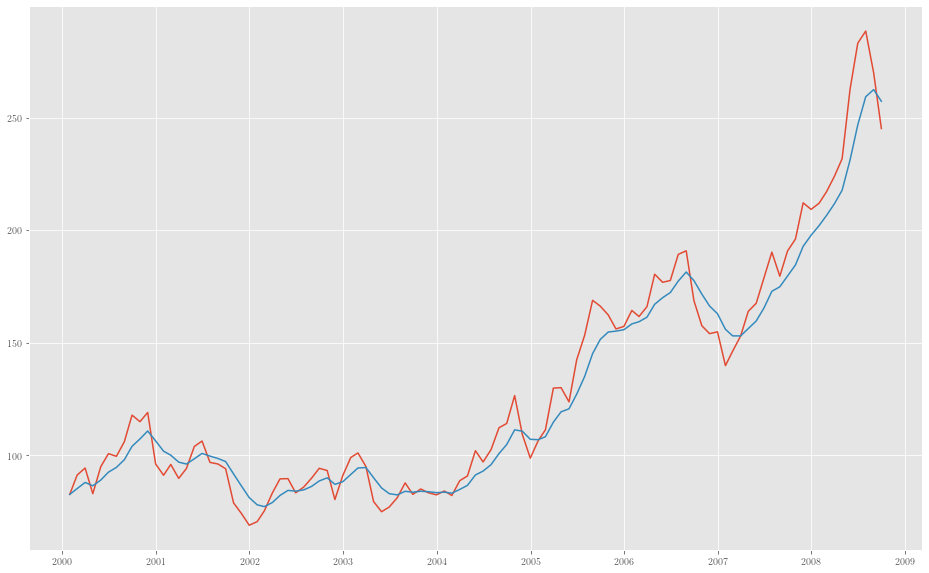

In [30]:
# The preceeding example shows that exponential smoothing over-/underpredicts in the presence of a deterministic
# trend. In order to mitigate this problem one can first detrend and then use EWMA. We want to do this for the
# oil data again. 

oil_smoothed=EWMA(oil['oil'].values,0.3)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])
plt.plot(oil['date'],oil_smoothed)

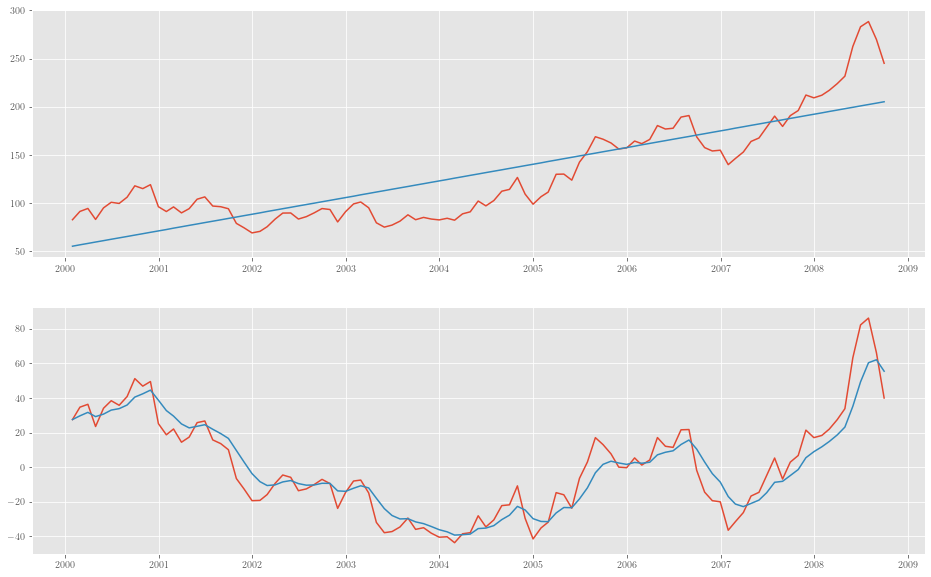

In [13]:
# Now first estimate the deterministic linear trend, detrend the series and then smooth the detrended series
# using EWMA with alpha=0.3. Plot everything.
y=oil['oil']

# We use days as the time variable.
t_periods=[2000+i/12 for i in range(105)]
X=sm.add_constant(t_periods)
model = sm.OLS(y,X)
result = model.fit()

# Get trend and detrend.
trend = result.predict(X)
oil_detrended = y-trend

# Smooth.
oil_detrended_smoothed=EWMA(oil_detrended.values,0.3)

# Plot.
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(oil['date'],oil['oil'])
ax[0].plot(oil['date'],trend)
ax[1].plot(oil['date'],oil_detrended)
ax[1].plot(oil['date'],oil_detrended_smoothed)

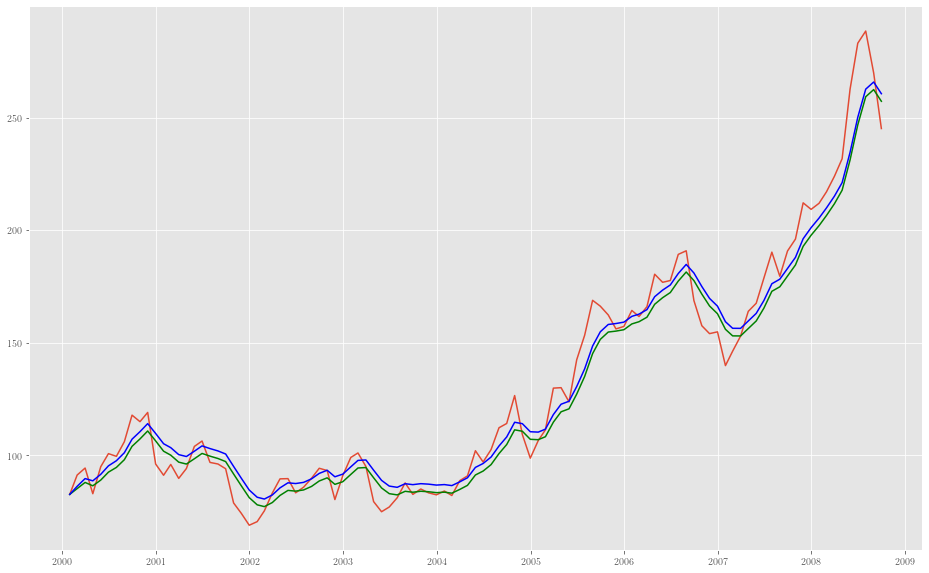

In [14]:
# Add the trend and the smoothed detrended series back together and plot the result against the original series.
oil_smoothed_2=trend+oil_detrended_smoothed
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])
plt.plot(oil['date'],oil_smoothed,c='green')
plt.plot(oil['date'],oil_smoothed_2,c='blue')

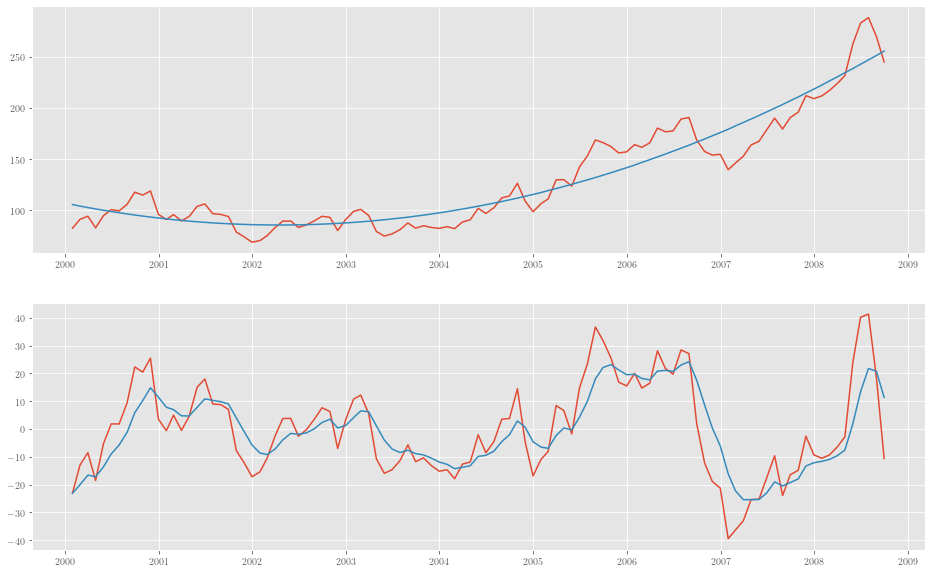

In [15]:
# Now estimate the deterministic quadratic trend, detrend the series and then smooth the detrended series
# using EWMA with alpha=0.3. Plot everything.
y=oil['oil']

t_periods=[2000+i/12 for i in range(105)]
t_periods_2=[(2000+i/12)**2 for i in range(105)]
X=np.array([t_periods,t_periods_2])
X=X.transpose()
X_2=sm.add_constant(X)
model1 = sm.OLS(y,X_2)
result1 = model1.fit()

# Get trend and detrend.
trend1 = result1.predict(X_2)
oil_detrended1 = y-trend1

# Smooth.
oil_detrended_smoothed1=EWMA(oil_detrended1.values,0.3)

# Plot.
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(oil['date'],oil['oil'])
ax[0].plot(oil['date'],trend1)
ax[1].plot(oil['date'],oil_detrended1)
ax[1].plot(oil['date'],oil_detrended_smoothed1)

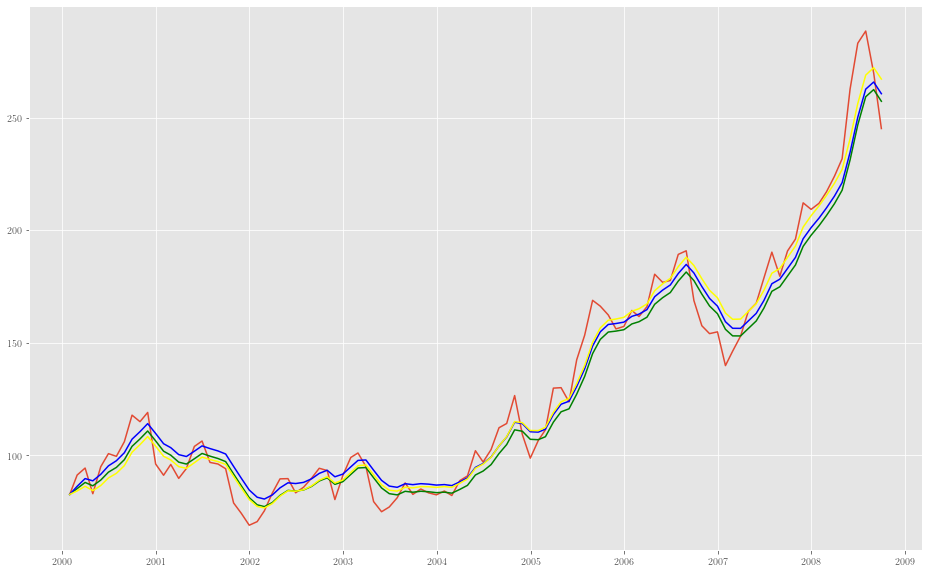

In [36]:
# Add the trend and the smoothed detrended series back together and plot the result against the original series.
oil_smoothed_21=trend1+oil_detrended_smoothed1
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])
plt.plot(oil['date'],oil_smoothed,c='green')
plt.plot(oil['date'],oil_smoothed_2,c='blue')
plt.plot(oil['date'],oil_smoothed_21,c='yellow')

## Hodrick-Prescott filter

The Hodrick-Prescott (HP) filter is a benchmark for getting rid of trend movements in data. 

- Especially used in macroeconomics
- Nonparametric technique
- used to dissolve a time series into a trend/cyclical component, without reference to  economic theory or the need to specify the trend a priori. 
- It depends on a tuning parameter that controls the degree of smoothing. 
- This method is broadly employed in applied macroeconomics utilized in central banks, international economics agencies, industry, and government.

The Hodrick-Prescott filter solves the optimization problem

\begin{align}
\min_\tau\sum_{t=1}^T(y_t-\tau_t)^2+\lambda\sum_{t=2}^{T-1}[(\tau_{t+1}-\tau_t)-(\tau_t-\tau_{t-1})]^2
\end{align}

where $\tau=\begin{bmatrix}\tau_1&\ldots&\tau_T\end{bmatrix}$ is the smoothed series and $\lambda$ a hyperparameter to be chosen beforehand. In the lecture slides - or simply by computing the FOC - you can see that solving this for optimal $\tau$ amounts to solving a system of linear equations.

The “penalty” parameter λ, controls the smoothness of the resulting trend. The larger λ ,the smoother the trend. HP recommend to set λ equal to 100, 1600, 14400 for annual, quarterly, monthly data.

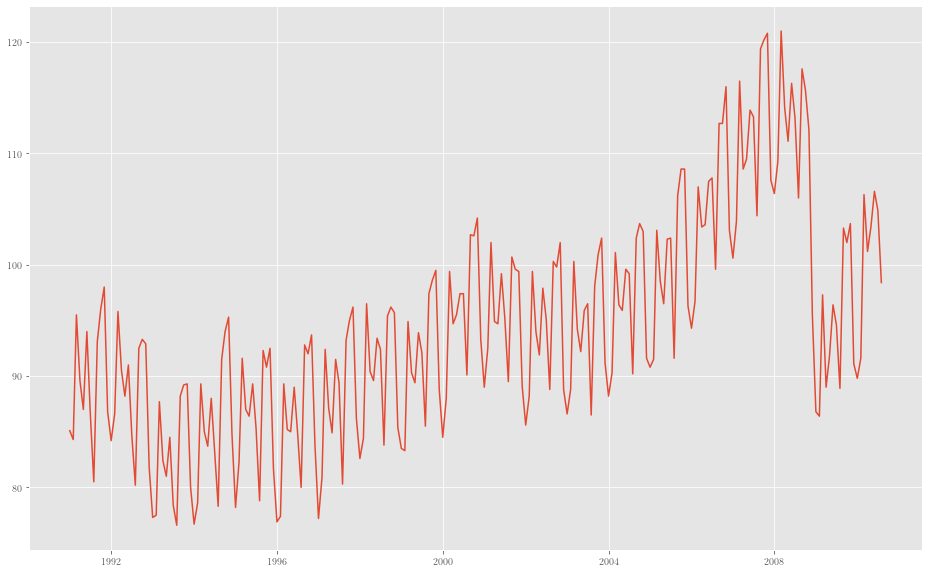

In [41]:
# Plot the prod-data. It is monthly data.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(prod['time'],prod['prod'])

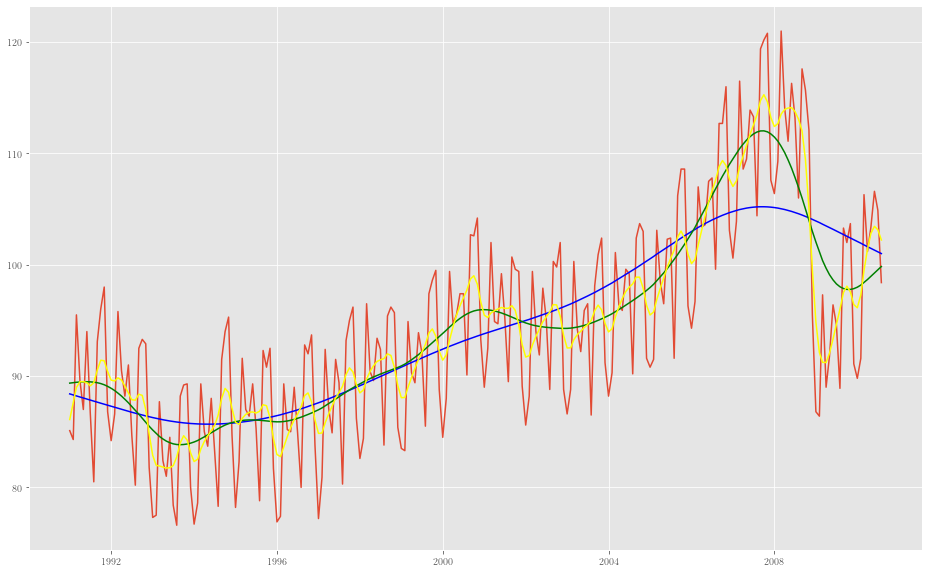

In [42]:
# Use the statsmodels command hpfilter to estimate the smoothed series for the prod-data.
# Note that the command returns two arrays. One for the trend and one for the cycle. 
# The cycle simply is the original series minus the trend.
# The documentation from statsmodels mentions different optimal values for lambda: 
# 129600(monthly), 1600(quarterly), 6.25(annual)
cycle_129600, trend_129600=sm.tsa.filters.hpfilter(prod['prod'],lamb=129600)
cycle_1600, trend_1600=sm.tsa.filters.hpfilter(prod['prod'],lamb=1600)
cycle_625, trend_625=sm.tsa.filters.hpfilter(prod['prod'],lamb=6.25)


# Plot the original series together with the smoothed series.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(prod['time'],prod['prod'])
plt.plot(prod['time'],trend_129600,c='blue')
plt.plot(prod['time'],trend_1600,c='green')
plt.plot(prod['time'],trend_625,c='yellow')

## Seasonal Adjustment 

Our goal is spot all seasonality in the data and control for it, i.e. eliminate the seasonal effects. In order to do so we assume a multiplicative model

\begin{align}
y_t=L_t\cdot C_t\cdot S_t\cdot I_t
\end{align}

and:
- first estimate $G_t=L_t\cdot C_t$ with some smoothing method or other detrending procedure. 
- Then we obtain $S_t\cdot I_t=y_t/(L_t\cdot C_t)$, by rearranging the definition above. 
- Further we elimate $I_t$ by averaging over seasonal periods and finally we can estimate a seasonally adjusted series via $y_t^{\text{SA}}=y_t/S_t$.

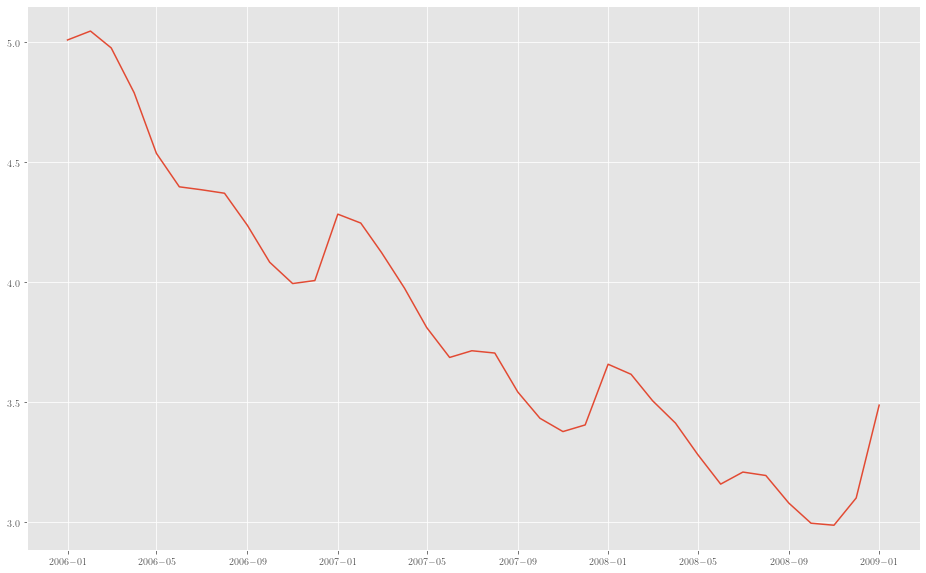

In [43]:
# Plot the unemployment-data against time. What seasonality can you detect?
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])

In [11]:
# Compute the trend via a simple moving average. Plot the trend against the original data.

In [22]:
# Write a function to compute moving averages 
def ma(data,periods):
    if periods%2==0:
        k=int(periods/2)
        weights=[1/(2*periods)]+[(1/periods) for i in range(periods-1)]+[1/(2*periods)]
        smoothed=np.convolve(data,weights)
        result=smoothed[k:-k]
        #adapt at the boundaries
        for i in range(k):
            weights=[(1/(k+1+i)) for j in range(k+i)]+[1/(2*(k+1+i))]
            result[i]=np.average(data[:k+1+i],weights=weights)
            weights.reverse()
            result[-(i+1)]=np.average(data[-(k+1+i):],weights=weights)
        return(result)
    else:
        k=round(periods/2)
        weights=[(1/periods) for i in range(periods)]
        smoothed=np.convolve(data,weights)
        result=smoothed[k:-k]
        #adapt at the boundaries
        for i in range(k):
            weights=[(1/(k+1+i)) for j in range(k+i)]
            result[i]=np.average(data[:k+i],weights=weights)
            weights.reverse()
            result[-(i+1)]=np.average(data[-(k+i):],weights=weights)
        return(result)# Compute the trend via a simple moving average. Plot the trend against the original data.

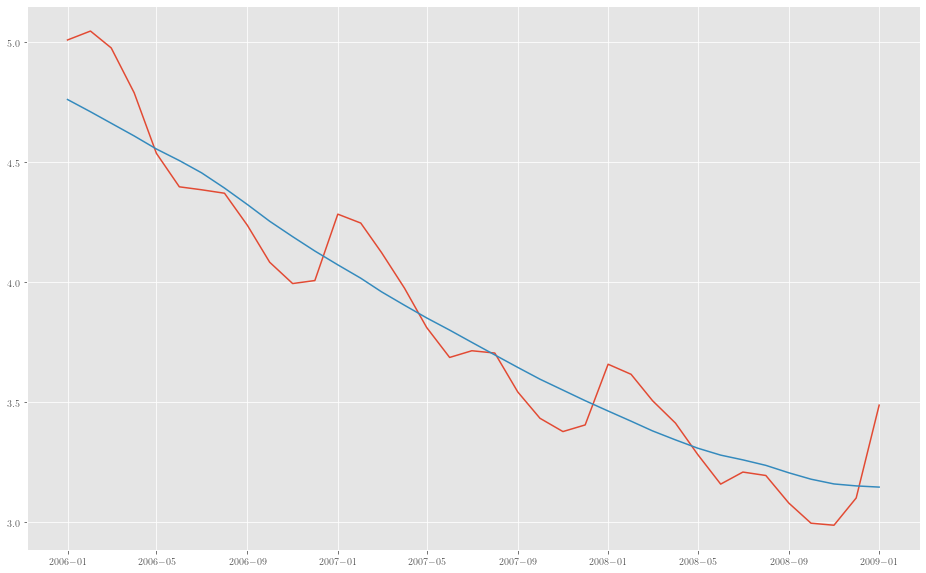

In [23]:
# Compute the trend via a simple moving average. Plot the trend against the original data.
unemp_smoothed_ma=ma(unemp['unemp'].values,12)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])
plt.plot(unemp['time'],unemp_smoothed_ma)

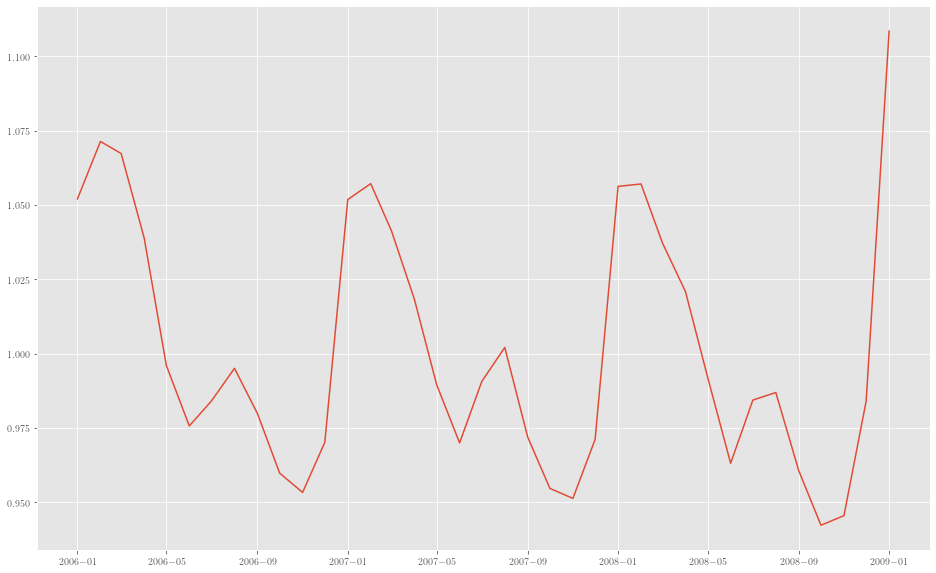

In [25]:
# Inspect the remainder (after removing the trend)
rest=unemp['unemp'].values/unemp_smoothed_ma
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],rest)

In [26]:
# Compute monthwise averages of S_t*I_t. This eliminates I_t and gives a seasonal index. Then you deseasonalize
# the original series by deviding each value with the corresponding index.
seasonal_index=[0 for i in range(12)]
weights=[1/4]+[1/3 for i in range(11)]
for i in range(len(rest)):
    seasonal_index[i%12]+=weights[i%12]*rest[i]
    
# It is important to actually generate a copy of the unemp-data. Otherwise changes to unemp_adj will
# always also change unemp['unemp'].values, since both point to the same list.
unemp_adj=unemp['unemp'].values.copy()
for i in range(len(unemp['unemp'].values)):
    unemp_adj[i]=unemp_adj[i]/seasonal_index[i%12]
unemp['unemp_seasonally_adj']=unemp_adj

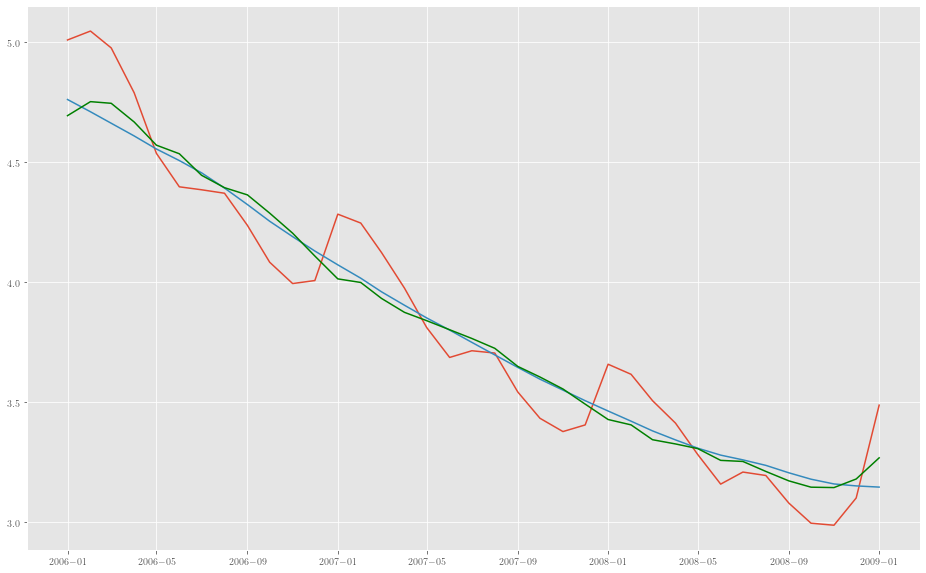

In [28]:
# Plot seasonally adjusted series against original series together with the smoothed series.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])
plt.plot(unemp['time'],unemp_smoothed_ma)
plt.plot(unemp['time'],unemp['unemp_seasonally_adj'],c='g')